## Pure shear experiment

This notebook builds upon the simple shear model to show models for _pure shear_ in which shear bands form in response to extensional / compressional deformation of the domain boundary.

We consider a rectangular, deforming domain with plastic-strain-softening, Drucker-Prager rheology which is subject to pure shear boundary conditions (the sides of the domain move in or out and the top moves to preserve the overall volume).

As before, the rheology is described by:

\begin{equation}
    \eta =  
        \begin{cases}
              \eta_0 & |\tau| < \tau_\textrm{yield} \\
              {\tau_\textrm{yield}} / {2 \left| \, \dot\varepsilon \, \right|} & \textrm{otherwise}
        \end{cases}
\end{equation}
where the yield stress, $\tau_\textrm{yield}$ is given by

\begin{equation}
    \tau_\textrm{yield} = C(\varepsilon_p) + \mu p 
\end{equation}

$ \left| \, \dot\varepsilon \, \right| $ is the second invariant of the strain rate tensor, $\varepsilon$ is its integral over time in regions where the yield stress is reached, $C$ is a cohesion, $\mu$ is a friction coefficient, and $p$ is the pressure.

The cohesion weakens with accumulated plastic strain as follows:

\begin{equation}
    C = c_0 + c_1 e^{ \left( -\varepsilon_\textrm{p} / \varepsilon_0 \right)}
\end{equation}

No healing of the cohesion is implemented in this example.


In [1]:
# %matplotlib inline
import matplotlib.pyplot as pyplot
import matplotlib.pylab as pylab
import numpy as np
import math
import os

import underworld as uw
from underworld import function as fn
from underworld import meshvariable as meshvariable
import glucifer

import mpi4py
comm = mpi4py.MPI.COMM_WORLD

In [2]:
# As a precaution ... keep workdir. Something in uw is cd'ing to crazy places within the python installation. 
# It seems to be gLucifer.

try:
    workdir
except NameError:
    workdir = os.path.abspath(".")
      
outputPath = os.path.join(workdir,"PureShear2D/")

if uw.rank() == 0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
    
comm.Barrier()   


Create mesh and finite element variables
------

Note: the use of a pressure-sensitive rheology suggests that it is important to use a Q2/dQ1 element 

In [3]:
minX  = -2.0
maxX  =  2.0
minXv = -1.0
maxXv =  1.0

resX = 256
resY = 64

# mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q2/DPC1"), 
#                                  elementRes  = ( resX, resY), 
#                                  minCoord    = ( minX, 0.), 
#                                  maxCoord    = ( maxX, 1.),
#                                  periodic    = [False, False]  ) 

mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q2/DPC1"), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( minX, 0.), 
                                 maxCoord    = ( maxX, 1.),
                                 periodic    = [False, False]  ) 



velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

### Boundary conditions

Pure shear with moving  walls — all boundaries are zero traction with 

In [4]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
base   = mesh.specialSets["MinJ_VertexSet"]
top    = mesh.specialSets["MaxJ_VertexSet"]

allWalls = iWalls + jWalls

velocityBCs = uw.conditions.DirichletCondition( variable        = velocityField, 
                                                indexSetsPerDof = (iWalls, base) )

for index in mesh.specialSets["MinI_VertexSet"]:
    velocityField.data[index] = [minXv, 0.]
for index in mesh.specialSets["MaxI_VertexSet"]:
    velocityField.data[index] = [maxXv, 0.]
    

### Setup the material swarm and passive tracers

The material swarm is used for tracking deformation and history dependence of the rheology

Passive swarms can track all sorts of things but lack all the machinery for integration and re-population

In [5]:
swarm         = uw.swarm.Swarm( mesh=mesh )
swarmLayout   = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

surfaceSwarm = uw.swarm.Swarm( mesh=mesh )

deformationSwarm = uw.swarm.Swarm ( mesh=mesh )

### Create a particle advection system

Note that we need to set up one advector systems for each particle swarm (our global swarm and a separate one if we add passive tracers).

In [6]:
advector        = uw.systems.SwarmAdvector( swarm=swarm,            velocityField=velocityField, order=2 )
advector2       = uw.systems.SwarmAdvector( swarm=surfaceSwarm,     velocityField=velocityField, order=2 )
advector3       = uw.systems.SwarmAdvector( swarm=deformationSwarm, velocityField=velocityField, order=2 )

### Add swarm variables

We are using a single material with a single rheology. We need to track the plastic strain in order to have some manner of strain-related softening (e.g. of the cohesion or the friction coefficient). For visualisation of swarm data we need an actual swarm variable and not just the computation.

Other variables are used to track deformation in the shear band etc.

**NOTE**:  Underworld needs all the swarm variables defined before they are initialised or there will be / can be memory problems (at least it complains about them !). That means we need to add the monitoring variables now, even if we don't always need them.

In [7]:
plasticStrain  = swarm.add_variable( dataType="double",  count=1 )

# Tracking different materials

materialVariable = swarm.add_variable( dataType="int", count=1 )

# These ones are for monitoring of the shear bands

stretching = swarm.add_variable( dataType="double", count=mesh.dim)
orientation = swarm.add_variable( dataType="double", count=1)

# passive markers at the surface

surfacePoints = np.zeros((1000,2))
surfacePoints[:,0] = np.linspace(minX, maxX, 1000)
surfacePoints[:,1] = 0.8

surfaceSwarm.add_particles_with_coordinates( surfacePoints )
pass

deformationVariable = deformationSwarm.add_variable( dataType="double", count=1)
deformationPoints = np.array(np.meshgrid(np.linspace(minX, maxX, 1000), np.linspace(0.0, 0.8, 250))).T.reshape(-1,2)
deformationSwarm.add_particles_with_coordinates( deformationPoints )
pass


### Initialise swarm variables



In [8]:
# Stretching - assume an initial orientation aligned with the x-axis

stretching.data[:,0] = 1.0
stretching.data[:,1] = 0.0

# This is a work-variable for visualisation

orientation.data[:] = 0.0

# plastic strain - weaken a region at the base close to the boundary (a weak seed but through cohesion softening)

def gaussian(xx, centre, width):
    return ( np.exp( -(xx - centre)**2 / width ))

def boundary(xx, minX, maxX, width, power):
    zz = (xx - minX) / (maxX - minX)
    return (np.tanh(zz*width) + np.tanh((1.0-zz)*width) - math.tanh(width))**power

# weight = boundary(swarm.particleCoordinates.data[:,1], 10, 4) 

plasticStrain.data[:] = 0.1 * np.random.rand(*plasticStrain.data.shape[:])
plasticStrain.data[:,0] *= gaussian(swarm.particleCoordinates.data[:,0], 0.0, 0.025) 
plasticStrain.data[:,0] *= gaussian(swarm.particleCoordinates.data[:,1], 0.0, 0.025) 
plasticStrain.data[:,0] *= boundary(swarm.particleCoordinates.data[:,0], minX, maxX, 10.0, 2) 

# 

deformationVariable.data[:,0] = deformationSwarm.particleCoordinates.data[:,1]%0.1


In [9]:
if comm.size == 1:   # Serial
    xx = np.arange(-20, 20, 0.01)
    yy = boundary(xx, minX, maxX, 10, 2)
    pyplot.scatter(xx,yy)

### Material distribution in the domain.



In [10]:
# Initialise the 'materialVariable' data to represent different materials. 
materialV = 1 # viscoplastic
materialA = 0 # accommodation layer a.k.a. Sticky Air

# The particle coordinates will be the input to the function evaluate (see final line in this cell).
# We get proxy for this now using the input() function.

coord = fn.input()

# Setup the conditions list for the following conditional function. Where the
# z coordinate (coordinate[1]) is less than the perturbation, set to lightIndex.

conditions = [ (       coord[1] > 0.8 , materialA ),
               (       True ,           materialV ) ]

# The actual function evaluation. Here the conditional function is evaluated at the location
# of each swarm particle. The results are then written to the materialVariable swarm variable.

materialVariable.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

### Define the viscosity function

In this case, the viscosity of material which has not reached the yield criterion is simply going to be a constant. Nevertheless, it is useful to define it here as a function and write the remaining code such that it is not changed if we introduce additional materials or a dependence on another set of equations.



In [11]:
viscosityMap = { materialA: 0.001, materialV:1.0 }

backgroundViscosityFn  = fn.branching.map( fn_key = materialVariable, 
                                           mapping = viscosityMap )



### Define a yield criterion (function)

\begin{equation}
    \tau_\textrm{yield} = C(\varepsilon_p) + \mu p 
\end{equation}

The yield strength described above needs to be evaluated on the fly at the particles (integration points). It therefore needs to be a function composed of mesh variables, swarm variables, constants, and mathematical operations.


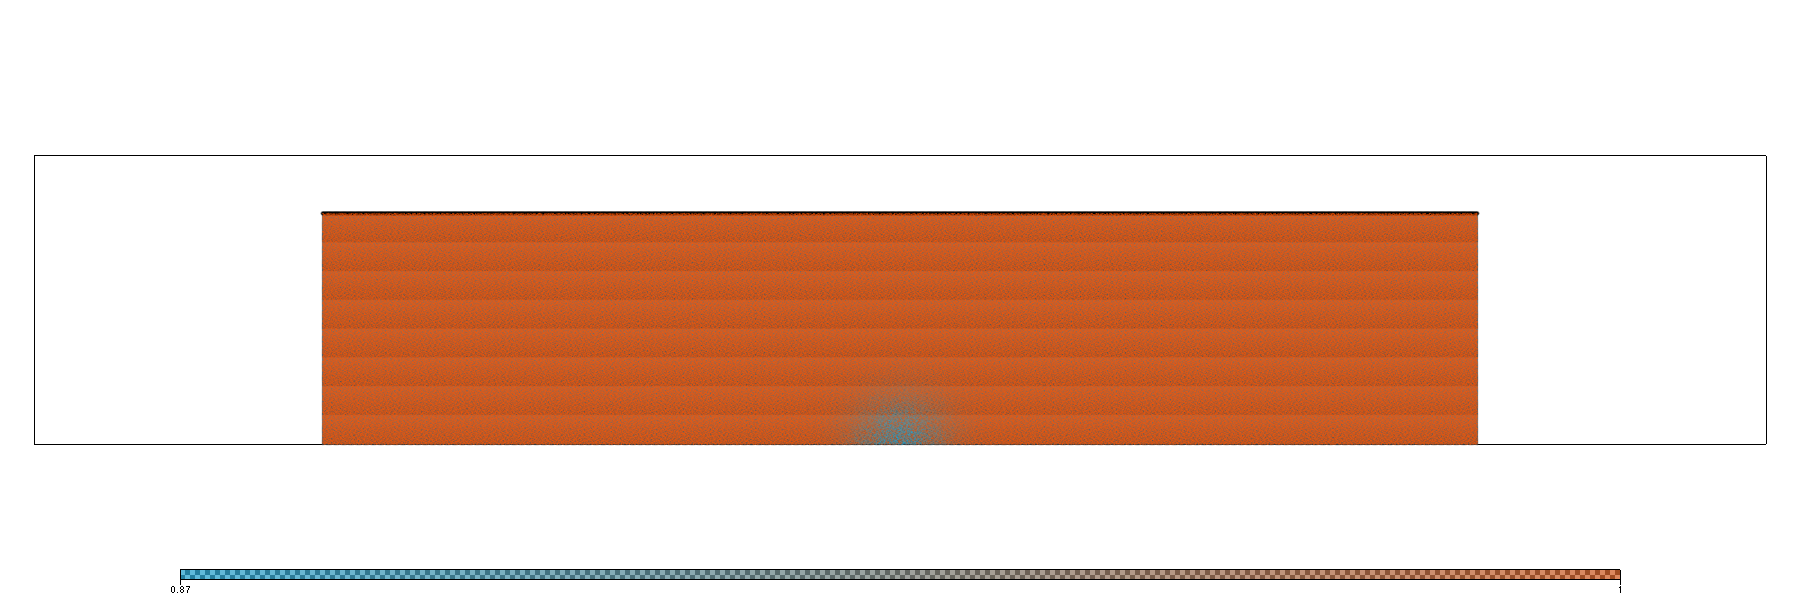

In [19]:
# Cohesion - a function of swarm variables

cohesionInf     = fn.misc.constant(0.25)
cohesion0       = fn.misc.constant(0.75)
referenceStrain = fn.misc.constant(0.5)

cohesionFn =  cohesionInf + cohesion0 * fn.math.exp(-plasticStrain / referenceStrain )

# Friction - in this form it could also be made to weaken with strain

frictionInf     = fn.misc.constant(0.5)
frictionFn      = frictionInf 


# Drucker-Prager yield criterion

yieldStressFn   = cohesionFn + frictionFn * pressureField


# Plot it and see (it will be the cohesion in the first run through) 

figYieldStress = glucifer.Figure( figsize=(1800,600), boundingBox=((-3.0, 0.0, 0.0), (3.0, 1.0, 0.0)) )
figYieldStress.append( glucifer.objects.Points(swarm, yieldStressFn , pointSize=3.0, fn_mask=materialVariable, colours="#00BBFF:0.5 #FF5500:0.5") )
figYieldStress.append( glucifer.objects.Points(surfaceSwarm, pointSize=5.0, colours="#440000:0.9 #440000:0.9", colourBar=False) )
figYieldStress.append( glucifer.objects.Points(deformationSwarm, deformationVariable, pointSize=3.0, colourBar=False,
                                               colours="#444444:0.75 #666666:0.75") )

figYieldStress.show()


### Define composite (yielding) rheology

The actual constitutive behaviour is a composite of the behaviour below the yield strength and the reduced viscosity required to ensure that the stress remains bounded by the yield envelope.

\begin{equation}
    \eta =  
        \begin{cases}
              \eta_0 & |\tau| < \tau_\textrm{yield} \\
              {\tau _ \textrm{yield}} / {2 \left| \, \dot\varepsilon \, \right|} & \textrm{otherwise}
        \end{cases}
\end{equation}

**Note**: The $1.0^{-18}$ added to the strain-rate is supposed to be a small number preventing the rheology from blowing up if the velocity field is zero. Obviously this number should be much smaller than the expected strain rate !

In [ ]:
# first define strain rate tensor

strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateFn)

# now compute a viscosity assuming yielding

min_viscosity = 0.001  # same as the air ... 

yieldingViscosityFn =  0.5 * yieldStressFn / (strainRate_2ndInvariantFn+1.0e-18)

viscosityFn = fn.exception.SafeMaths( fn.misc.max(fn.misc.min(yieldingViscosityFn, 
                                                              backgroundViscosityFn), 
                                                  min_viscosity))


### Deviatoric stress 

The deviatoric stress is computed from the constitutive law based on the viscosity that
results from the solution to the non-linear Stokes equation.

**Note:** the deviatoric stress is defined in terms of functions we have defined already
but the value will be meaningless if the viscosityFn is modified in any way after the 
solve is complete because evaluation is made only when the values at particular points are needed.

In [ ]:

# DeviatoricStress

devStressFn = 2.0 * viscosityFn * strainRateFn

### Buoyancy forces

In this example, no buoyancy forces are considered. However, to establish an appropriate pressure gradient in the material, it would normally be useful to map density from material properties and create a buoyancy force.

In [ ]:
# buoyancy force term (not used in this geometry)

z_hat   = ( 0.0, 0.0 )
buoyancyFn = z_hat 

System setup
-----

Setup a Stokes equation system and connect a solver up to it.  

In this example, no buoyancy forces are considered. However, to establish an appropriate pressure gradient in the material, it would normally be useful to map density from material properties and create a buoyancy force.

In [ ]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               swarm         = swarm, 
                               conditions    = [velocityBCs,],
                               fn_viscosity  = viscosityFn, 
                               fn_bodyforce  = None )


solver = uw.systems.Solver( stokesPIC )

## Initial solve (drop the non-linearity the very first solve only)

penaltyNumber=1.0e6
solver.set_inner_method("mumps")
solver.set_penalty(penaltyNumber)
stokesPIC.fn_viscosity = viscosityFn
solver.solve( nonLinearIterate=True )
solver.print_stats()


In [ ]:
figVelocityPressure = glucifer.Figure( figsize=(1200,400), boundingBox=((-3.0, 0.0, 0.0), (3.0, 1.0, 0.0)) )
figVelocityPressure.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling=.1) )
figVelocityPressure.append( glucifer.objects.Surface(mesh, pressureField) )
figVelocityPressure.append( glucifer.objects.Points(surfaceSwarm, pointSize=5.0, colourBar=False, colours="#440000 #440000") )
figVelocityPressure.show()


In [ ]:
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

(area,) = surfaceArea.evaluate()
(p0,) = surfacePressureIntegral.evaluate() 

pressureField.data[:] -= p0 / area

In [ ]:
help(glucifer.Figure)

In [ ]:
# The stress is only guaranteed to be accurate when integrated across an element. Fluctuations
# within an element can be significant. Mapping to the mesh can help

meshDevStress = uw.mesh.MeshVariable( mesh, 1 )

projectorStress = uw.utils.MeshVariable_Projection( meshDevStress, fn.tensor.second_invariant(devStressFn), type=0 )
projectorStress.solve()

figMeshStress = glucifer.Figure( figsize=(1200,400), boundingBox=((-3.0, 0.0, 0.0), (3.0, 1.0, 0.0)) )
figMeshStress.append( glucifer.objects.Surface(mesh, meshDevStress  , colours="#0044BB, #777777, #FF9900") )
figMeshStress.append( glucifer.objects.Points(surfaceSwarm, pointSize=5.0, colours="#440000 #440000", colourBar=False) )

figMeshStress.show()

In [ ]:
curlV = velocityField.fn_gradient[1] - velocityField.fn_gradient[2]
figStrain = glucifer.Figure( figsize=(1200,400), boundingBox=((-3.0, 0.0, 0.0), (3.0, 1.0, 0.0)) )
figStrain.append( glucifer.objects.Surface(mesh, curlV) )
figStrain.append( glucifer.objects.Points(swarm, plasticStrain, pointSize=4.0, 
                  fn_mask=materialVariable,  colours="#FF6600:0.5, #555555:0.25, Blue:0.5") )
figStrain.append( glucifer.objects.Points(surfaceSwarm, pointSize=5.0, colours="#440000 #440000", colourBar=False) )


figStrain.show()

## Main simulation loop
-----

In [ ]:

# Stepping. Initialise time and timestep.
time = 0.
step = 0
nsteps = 250

while step<nsteps:
    # Obtain V,P and remove null-space / drift in pressure
    
    solver.solve( nonLinearIterate=True )
    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate() 
    pressureField.data[:] -= p0 / area
    
    comm.Barrier()

    dt = advector.get_max_dt()
    advector.integrate(dt)
    advector2.integrate(dt)
    advector3.integrate(dt)
    
    # Stretch mesh to match boundary conditions
    
    minX += minXv * dt
    maxX += maxXv * dt
    
    mesh2 = uw.mesh.FeMesh_Cartesian( elementType = ("Q2/DPC1"), 
                                      elementRes  = (resX, resY), 
                                      minCoord    = ( minX, 0.), 
                                      maxCoord    = ( maxX, 1.),
                                      periodic    = [False, False]  ) 


    with mesh.deform_mesh():
        mesh.data[:] = mesh2.data[:]
    
    swarm.update_particle_owners()
        
    swarmVgrad = velocityField.fn_gradient.evaluate(swarm)
  
    stretching.data[:,0] += dt * (swarmVgrad[:,0] * stretching.data[:,0] + swarmVgrad[:,1] * stretching.data[:,1])
    stretching.data[:,1] += dt * (swarmVgrad[:,2] * stretching.data[:,0] + swarmVgrad[:,3] * stretching.data[:,1])
        
    swarmYield = viscosityFn.evaluate(swarm) < backgroundViscosityFn.evaluate(swarm)
         
    swarmStrainRateInv = strainRate_2ndInvariantFn.evaluate(swarm)

    weight = boundary(swarm.particleCoordinates.data[:,0], minX, maxX, 10.0, 2) 
    plasticStrainIncrement = dt * np.where(swarmYield, swarmStrainRateInv , 0.0 )
    plasticStrainIncrement[:,0] *= weight
    plasticStrain.data[:] += plasticStrainIncrement
    
    comm.Barrier()

    if (step%5 ==0):      
        figYieldStress.save_image(     outputPath + "figYield-" +str(frictionInf.evaluate([0.0,0.0]))+"-" + str(step).zfill(4))
        
        figVelocityPressure.save_image(     outputPath + "figVP-" +str(frictionInf.evaluate([0.0,0.0]))+"-" + str(step).zfill(4))
        
        projectorStress = uw.utils.MeshVariable_Projection( meshDevStress, fn.tensor.second_invariant(devStressFn), type=0 )
        projectorStress.solve()

        figStrain.save_image(      outputPath + "figStrain-"     +str(frictionInf.evaluate([0.0,0.0]))+"-" + str(step).zfill(4))


        
    if uw.rank()==0:   
        print('step = {0:6d}; time = {1:.3e};'.format(step,time))
        print("Plastic Strain - max = {}".format(plasticStrain.evaluate(swarm).max()))

    comm.Barrier()   
        
    time += dt
    step += 1
    
## Repeat ...     

Post simulation analysis
-----

**Note**: most of the figures (e.g. `figYieldStress`) are defined entirely in terms of StGermain functions. This will automatically plot the latest version of the function evaluated at each of the particle / mesh locations. However, if the figure requires `numpy` data evaluations then these evaluations will not be embedded in the figure itself and will have to be called beforehand. 

In [ ]:
figYieldStress.show()

In [ ]:
figVelocityPressure.show()

In [ ]:
figStrain.show()

In [ ]:
projectorStress = uw.utils.MeshVariable_Projection( meshDevStress, fn.tensor.second_invariant(devStressFn), type=0 )
projectorStress.solve()

figMeshStress.show()

### Particle shear-strain measure

An initially horizontal line will be stretched along the direction of shear strain. This is one way to identify the shear bands but it's not particularly helpful for this example !

In [ ]:
swarmVgrad = velocityField.fn_gradient.evaluate(swarm)

meshStretching = uw.mesh.MeshVariable( mesh, 2 )

orientation.data[:,0] = np.where( np.abs(swarmVgrad[:,0]) > 1.1, -180 * np.arctan2(stretching.data[:,1] / math.pi, stretching.data[:,0]) / math.pi, 0.0)

projectStretching = uw.utils.MeshVariable_Projection( meshStretching, stretching, type=0 )
projectStretching.solve()
meshStretching.data[:,0] /= np.sqrt( meshStretching.data[:,0]**2 + meshStretching.data[:,1]**2 )
meshStretching.data[:,1] /= np.sqrt( meshStretching.data[:,0]**2 + meshStretching.data[:,1]**2 )


figMeshStretching = glucifer.Figure( figsize=(1200, 400))
figMeshStretching.append( glucifer.objects.VectorArrows(mesh, meshStretching, scaling=0.1, arrowHead=0.00001, resolutionI=100, resolutionJ=25)) 
figMeshStretching.append( glucifer.objects.Points(swarm, orientation , pointSize=5.0, colours="#448800, #666666:0.0, #0099FF") )
figMeshStretching.show()
